In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib import animation, rc
from lbow.transient import HalfPlaneModel, OneLayerModel

In [3]:
rc('animation', html='html5')

# Impulse response of atmospheric gravity waves

This notebook illustrates the impulse response of atmospheric gravity waves. To this end, the semi-analytical solution of uniform, stratified flow over a "transient" Gaussian hill is calculated. The goal of this theoretical case is to show how gravity waves are excited by the source and then travel away and die out in time. The semi-analytical solution is obtained with LBoW, which solves linear theory of buoyancy waves. A Gaussian shape is chosen over the classical bell shape (Witch of Agnesi) as the spectrum of the Gaussian falls off faster, allowing a coarser grid resolution.

Copyright 2022 Dries Allaerts

Licensed under the Apache License, Version 2.0.

## Set-up

### Input parameters

Flow parameters: wind speed U and Brunt Vaisala frequency N

In [4]:
U = 10   # Wind speed [m/s]
N = 0.01 # Brunt-Vaisala frequency [1/s]

Hill shape $h\left(x,t\right) = h_{max}\exp\left(-\frac{x^2}{2L^2}\right)\exp\left(-\frac{t^2}{2\tau^2}\right)$


In [5]:
L = 1000.0   # Characteristic width of the hill [m]
hmax = 100.0 # Height of the hill [m]
tau = 360    # Characteristic time scale [s]

# Shape functions of the hill
hx = lambda x: hmax*np.exp(-(x/L)**2/2)
ht = lambda t: np.exp(-(t/tau)**2/2)

Numerical parameters

In [6]:
Lx = 100.0e3  # Length of the numerical domain [m]
Nx = 250      # Number of grid points in then horizontal direction

In [7]:
T = 60 * 3600 # Time window [s]
Nt = 1440     # Number of grid points in the temporal dimension

Parameters for visualization

In [8]:
Lz = 15.0e3 # Height up to which solution is calculated [m]
Nz = 151    # Number of vertical levels to be used

### Numerical grid

In [9]:
xs,dx = np.linspace(-Lx/2,Lx/2,Nx,endpoint=False,retstep=True)
print('Horizontal grid resolution is {} m'.format(dx))

Horizontal grid resolution is 400.0 m


In [10]:
ts,dt = np.linspace(-T/2,T/2,Nt,endpoint=False,retstep=True)
print('Temporal resolution is {} s'.format(dt))

Temporal resolution is 150.0 s


In [11]:
zs,dz = np.linspace(0,Lz,Nz,retstep=True)
print('Vertical resolution is {} m'.format(dz))

Vertical resolution is 100.0 m


In [12]:
Xs,Ts = np.meshgrid(xs,ts,indexing='ij')

### Model

In [13]:
model = HalfPlaneModel(Xs,Ts,hx(Xs)*ht(Ts),U,N)

### Visualize hill

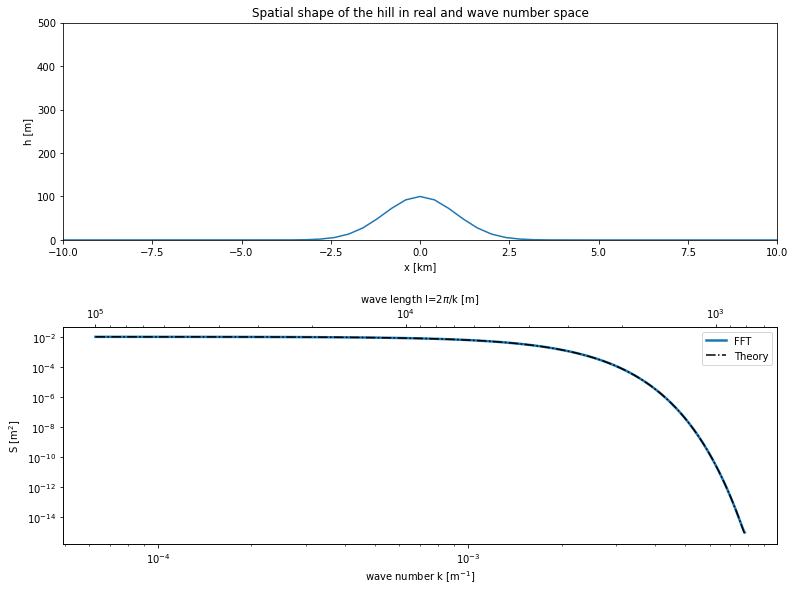

In [14]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(xs/1.e3,hx(xs))
ax[1].loglog(model.k[1:int(Nx/2),0],np.abs(model.hc[1:int(Nx/2),0]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-10,10],ylim=[0,500],xlabel='x [km]',ylabel='h [m]',
              title='Spatial shape of the hill in real and wave number space')
_ = ax[1].set(xlabel=r'wave number k [m$^{-1}$]',ylabel=r'S [m$^2$]')

# Theoretical Fourier transform pair
scale = np.mean(hx(Xs)*ht(Ts))
ax[1].loglog(model.k[1:int(Nx/2),0],scale*np.exp(-L**2*model.k[1:int(Nx/2),0]**2/2),'-.k',label='Theory')
ax[1].legend()
ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'wave length l=2$\pi$/k [m]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

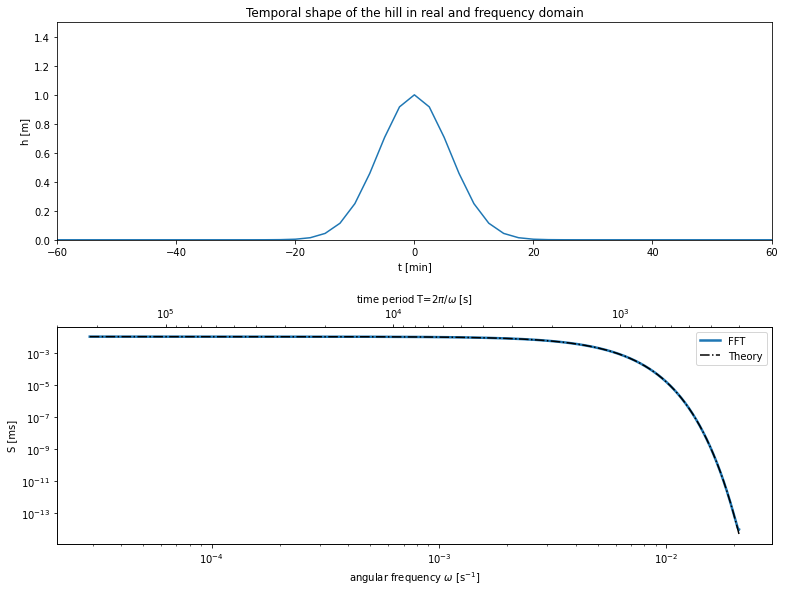

In [15]:
f,ax = plt.subplots(2,1,figsize=(12.8,9.6))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(ts/60,ht(ts))
ax[1].loglog(-model.omega[0,1:],np.abs(model.hc[0,1:]),linewidth=2.5,label='FFT')
_ = ax[0].set(xlim=[-60,60],ylim=[0,1.5],xlabel='t [min]',ylabel='h [m]',
             title='Temporal shape of the hill in real and frequency domain')
_ = ax[1].set(xlabel=r'angular frequency $\omega$ [s$^{-1}$]',ylabel=r'S [ms]')

# Theoretical Fourier transform pair
scale = np.mean(hx(Xs)*ht(Ts))
ax[1].loglog(-model.omega[0,1:],scale*np.exp(-tau**2*model.omega[0,1:]**2/2),'-.k',label='Theory')
ax[1].legend()
ax2 = ax[1].twiny()
ax2.set_xscale('log')
ax2.set_xlabel(r'time period T=2$\pi$/$\omega$ [s]')
_ = ax2.set_xlim((2*np.pi/ax[1].get_xlim()[0],2*np.pi/ax[1].get_xlim()[1]))

Note that $t=0$ corresponds to time when the perturbation at the surface is maximal

## Solve flow problem

In [16]:
%time eta = model.solve('eta',zs)

CPU times: user 2.18 s, sys: 830 ms, total: 3.01 s
Wall time: 2.66 s


In [17]:
%time w = model.solve('w',zs)

CPU times: user 2.2 s, sys: 1.08 s, total: 3.28 s
Wall time: 2.62 s


## Visualization

### Contourplots of vertical displacement at various time instances

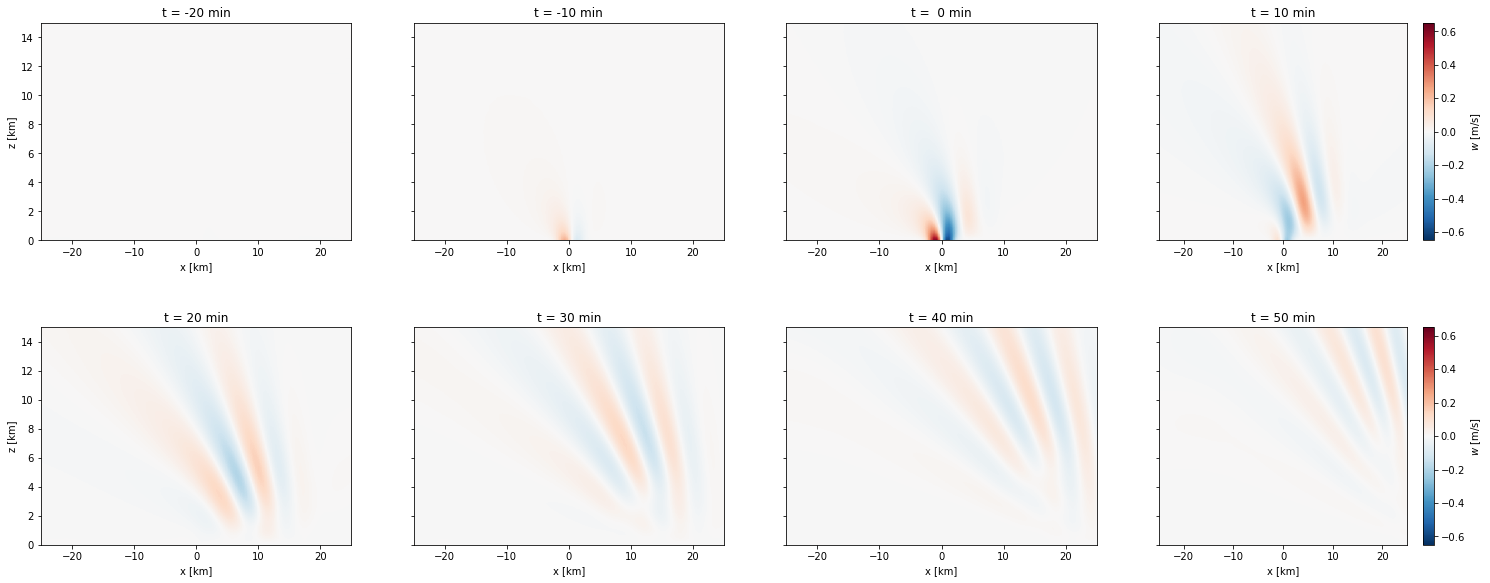

In [18]:
tindices = [712,716,720,724,728,732,736,740]
f,ax=plt.subplots(2,int(len(tindices)/2),sharey=True,figsize=(6.4*len(tindices)/2,9.6))
f.subplots_adjust(hspace=0.4)
ax = ax.ravel()

# Plot displacement in left axis
for axi,tindex in enumerate(tindices):
    im=ax[axi].imshow(
             w[...,tindex],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-0.65,vmax=0.65))
    _ = ax[axi].set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',title='t = {:2d} min'.format(int(ts[tindex]/60)))
cbar = f.colorbar(im,ax=ax[-1],shrink=1.0,label=r'$w$ [m/s]')
cbar = f.colorbar(im,ax=ax[int(len(tindices)/2)-1],shrink=1.0,label=r'$w$ [m/s]')
_ = ax[0].set(ylabel='z [km]')
_ = ax[int(len(tindices)/2)].set(ylabel='z [km]')

### Animation of the vertical displacement over time

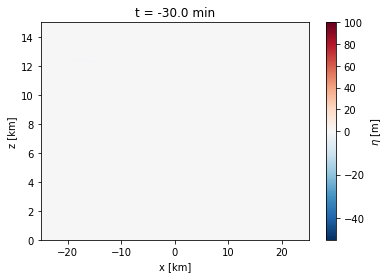

In [19]:
tstart = 708
frames = range(0,37,1)
f, ax = plt.subplots()
cax = ax.imshow(eta[...,tstart],
             origin='lower',
             extent=[xs[0]/1e3, xs[-1]/1e3, zs[0]/1e3, zs[-1]/1e3],
             aspect='auto',
             cmap='RdBu_r',
             norm=TwoSlopeNorm(vcenter=0.,vmin=-50,vmax=100))
cbar = f.colorbar(cax,ax=ax,shrink=1.0,label=r'$\eta$ [m]')
_ = ax.set(xlim=[-25,25],ylim=[0,15],xlabel='x [km]',ylabel='z [km]',
           title='t = {:4.1f} min'.format(ts[tstart]/60))

def animate(i):
    cax.set_array(eta[...,tstart+i])
    _ = ax.set(title='t = {:4.1f} min'.format(ts[tstart+i]/60))

anim = animation.FuncAnimation(f, animate, interval=400, frames=frames)

In [20]:
anim